<a href="https://colab.research.google.com/github/AvantikaKumarasamy/Monkey-game-C18/blob/master/22MIA1096_22MIA1085_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avantikakumarasamy","key":"5e41dc4e3bead29d58e19ae6ae818405"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d /content/oasis_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [5]:
# Define the path to your dataset directory
dataset_path = '/content/oasis_dataset/Data/'

# List of categories
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Check the number of images in each category
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    print(f"{category}: {len(os.listdir(folder_path))} images")

Non Demented: 67222 images
Very mild Dementia: 13725 images
Mild Dementia: 5002 images
Moderate Dementia: 488 images


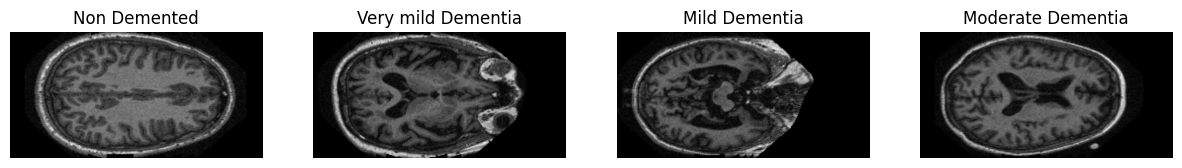

In [6]:
# Function to load and display sample images from each category
def display_sample_images(categories, dataset_path):
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        # Load a sample image
        sample_image_path = glob(os.path.join(dataset_path, category, '*.jpg'))[0]  # Adjust the extension if necessary
        sample_image = cv2.imread(sample_image_path)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

        # Plot the image
        axes[i].imshow(sample_image)
        axes[i].set_title(category)
        axes[i].axis('off')

display_sample_images(categories, dataset_path)

In [7]:
# Parameters
IMG_SIZE = 128  # Image size for resizing
BATCH_SIZE = 32  # Batch size for data generator
dataset_path = '/content/oasis_dataset/Data'  # Update this to your dataset path

# Categories (Ensure these match the folder names exactly in your dataset)
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']


In [8]:
# Data generator for rescaling and splitting
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values between 0 and 1
    validation_split=0.3       # 70% train, 30% validation/test split
)

# Train data generator (70% of data)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',         # Use the 'training' subset for training
    shuffle=True
)

# Validation data generator (30% of data, for validation and testing)
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',       # Use the 'validation' subset for validation
    shuffle=False
)

Found 60508 images belonging to 4 classes.
Found 25929 images belonging to 4 classes.


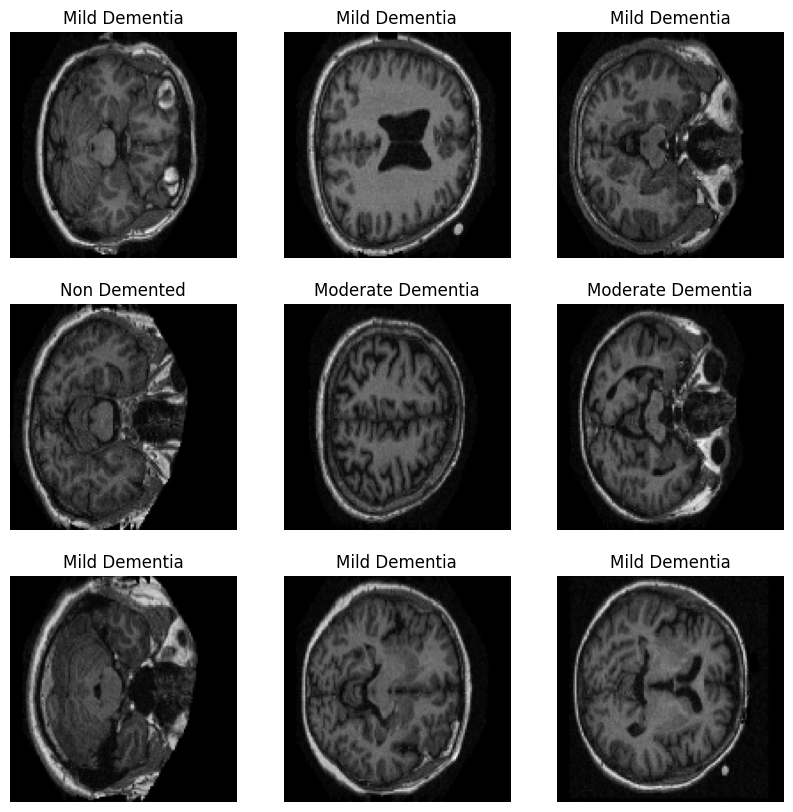

In [9]:
# Function to plot a few images from the generator
def plot_images_from_generator(generator):
    x_batch, y_batch = next(generator)  # Get a batch of images and labels
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display first 9 images in the batch
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        plt.title(categories[np.argmax(y_batch[i])])
        plt.axis('off')
    plt.show()

# Display sample images from the training generator
plot_images_from_generator(train_generator)

CNN MODEL

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [11]:
# Define the CNN model
model = Sequential()

# Convolutional layers with ReLU activations and max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to reduce overfitting
model.add(Dense(len(categories), activation='softmax'))  # Output layer with softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Stop training after 5 epochs of no improvement
    restore_best_weights=True     # Restore the best weights when stopping
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',           # Save the best model in Keras format
    monitor='val_accuracy',       # Monitor validation accuracy
    save_best_only=True           # Only save the model if the monitored quantity improves
)

In [13]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
    loss='categorical_crossentropy',        # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']                     # Monitor accuracy
)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.models import Model

# Define CNN model for MRI images
def create_cnn(input_shape):
    cnn_input = Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return cnn_input, x

# Define a dense network for genetic data
def create_genetic_network(input_shape):
    genetic_input = Input(shape=input_shape)
    y = Dense(64, activation='relu')(genetic_input)
    y = Dense(32, activation='relu')(y)
    return genetic_input, y

# Combine MRI and genetic inputs
mri_input_shape = (128, 128, 3)  # Example shape for MRI input
genetic_input_shape = (5,)  # Adjust this based on the number of genetic features

cnn_input, cnn_output = create_cnn(mri_input_shape)
genetic_input, genetic_output = create_genetic_network(genetic_input_shape)

# Concatenate CNN and genetic outputs
combined = concatenate([cnn_output, genetic_output])
combined = Dense(32, activation='relu')(combined)
combined = Dense(3, activation='softmax')(combined)  # For high, medium, low risk

# Define the model
model = Model(inputs=[cnn_input, genetic_input], outputs=combined)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:

# Step 3: Import necessary libraries and preprocess the data
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
import tensorflow as tf
import glob



# Define path to the downloaded images
image_paths = os.path.join(dataset_path, category)  # Adjust as needed to match file structure

# Limit the number of samples for demo purposes (or use len(image_paths) for full dataset)
num_samples = min(100, len(image_paths))  # Adjust sample size as desired

# Step 4: Load and preprocess MRI images
X_mri_train = []
for path in image_paths[:num_samples]:  # Limit to num_samples for demonstration
    img = load_img(path, target_size=(128, 128))  # Resize images to 128x128
    img_array = img_to_array(img) / 255.0         # Normalize pixel values to [0, 1]
    X_mri_train.append(img_array)

X_mri_train = np.array(X_mri_train)  # Convert list to numpy array

# Step 5: Generate dummy genetic data
genetic_feature_count = 5  # Example number of genetic features
X_genetic_train = np.random.rand(num_samples, genetic_feature_count)

# Step 6: Generate dummy risk labels (0 = Low, 1 = Medium, 2 = High risk)
y_labels = np.random.randint(0, 3, size=num_samples)  # Random labels
y_train = to_categorical(y_labels, num_classes=3)     # Convert to one-hot encoded format

# Step 7: Define and compile the model (same model setup as previously provided)
def create_cnn(input_shape):
    cnn_input = Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return cnn_input, x

def create_genetic_network(input_shape):
    genetic_input = Input(shape=input_shape)
    y = Dense(64, activation='relu')(genetic_input)
    y = Dense(32, activation='relu')(y)
    return genetic_input, y

# Define model input shapes
mri_input_shape = (128, 128, 3)
genetic_input_shape = (genetic_feature_count,)

# Create CNN and genetic networks
cnn_input, cnn_output = create_cnn(mri_input_shape)
genetic_input, genetic_output = create_genetic_network(genetic_input_shape)

# Combine CNN and genetic outputs
combined = concatenate([cnn_output, genetic_output])
combined = Dense(32, activation='relu')(combined)
combined = Dense(3, activation='softmax')(combined)  # Output layer for 3 risk levels

# Define and compile the combined model
model = Model(inputs=[cnn_input, genetic_input], outputs=combined)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the model with dummy data
batch_size = 16
epochs = 10  # Adjust as needed for training duration

history = model.fit(
    [X_mri_train, X_genetic_train],  # Training inputs
    y_train,                         # Training labels
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2  # Use 20% of data for validation
)

# Print model summary to verify architecture
model.summary()


IsADirectoryError: [Errno 21] Is a directory: '/'

In [21]:


# Step 3: Import necessary libraries and preprocess the data
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob

# Define path to the downloaded images in the structured directory
image_paths = glob.glob('/content/oasis_dataset/Data/*/*.png')


# Limit the number of samples for demo purposes (or use len(image_paths) for full dataset)
num_samples = min(200, len(image_paths))  # Adjust sample size as desired

# Load and preprocess MRI images
X_mri_train = []
for path in image_paths[:num_samples]:  # Limit to num_samples for demonstration
    img = load_img(path, target_size=(128, 128))  # Resize images to 128x128
    img_array = img_to_array(img) / 255.0         # Normalize pixel values to [0, 1]
    X_mri_train.append(img_array)

X_mri_train = np.array(X_mri_train)  # Convert list to numpy array

# Step 4: Generate dummy genetic data
genetic_feature_count = 5  # Example number of genetic features
X_genetic_train = np.random.rand(num_samples, genetic_feature_count)

# Step 5: Generate dummy risk labels (0 = Low, 1 = Medium, 2 = High risk)
y_labels = np.random.randint(0, 3, size=num_samples)  # Random labels
y_train = tf.keras.utils.to_categorical(y_labels, num_classes=3)  # Convert to one-hot encoded format

# Step 6: Define the CNN for MRI images
def create_cnn(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return cnn_input, x

# Define a dense network for dummy genetic data
def create_genetic_network(input_shape):
    genetic_input = Input(shape=input_shape)
    y = Dense(64, activation='relu')(genetic_input)
    y = Dense(32, activation='relu')(y)
    return genetic_input, y

# Combine MRI and genetic inputs
mri_input_shape = (128, 128, 3)
genetic_input_shape = (genetic_feature_count,)

# Create CNN and genetic network
cnn_input, cnn_output = create_cnn(mri_input_shape)
genetic_input, genetic_output = create_genetic_network(genetic_input_shape)

# Concatenate CNN and genetic outputs
combined = concatenate([cnn_output, genetic_output])
combined = Dense(32, activation='relu')(combined)
combined = Dense(3, activation='softmax')(combined)  # Output layer for 3 risk levels

# Define the combined model
model = Model(inputs=[cnn_input, genetic_input], outputs=combined)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the model with MRI and dummy genetic data
batch_size = 16
epochs = 10  # Adjust as needed

history = model.fit(
    [X_mri_train, X_genetic_train],  # Training inputs
    y_train,                         # Training labels
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2  # Use 20% of data for validation
)

# Optional: Evaluate or make predictions
# Example of making a prediction with new dummy data
predictions = model.predict([X_mri_train[:5], X_genetic_train[:5]])
print("Predicted risk levels for sample images:", np.argmax(predictions, axis=1))


KeyboardInterrupt: 

In [27]:
# Step 3: Import necessary libraries and preprocess the data
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import glob

# Define path to the downloaded images in the structured directory
image_paths = os.path.join('/content/oasis_dataset/Data/*/*.png')


# Limit the number of samples for demo purposes (or use len(image_paths) for full dataset)
num_samples = min(200, len(image_paths))  # Adjust sample size as desired

# Load and preprocess MRI images
X_mri_train = []
for path in image_paths[:num_samples]:  # Limit to num_samples for demonstration
    img = load_img(path, target_size=(128, 128))  # Resize images to 128x128
    img_array = img_to_array(img) / 255.0         # Normalize pixel values to [0, 1]
    X_mri_train.append(img_array)

X_mri_train = np.array(X_mri_train)  # Convert list to numpy array

# Step 4: Generate dummy genetic data
genetic_feature_count = 5  # Example number of genetic features
X_genetic_train = np.random.rand(num_samples, genetic_feature_count)

# Step 5: Generate dummy risk labels (0 = Low, 1 = Medium, 2 = High risk)
y_labels = np.random.randint(0, 3, size=num_samples)  # Random labels
y_train = tf.keras.utils.to_categorical(y_labels, num_classes=3)  # Convert to one-hot encoded format

# Step 6: Define the CNN for MRI images
def create_cnn(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(cnn_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return cnn_input, x

# Define a dense network for dummy genetic data
def create_genetic_network(input_shape):
    genetic_input = Input(shape=input_shape)
    y = Dense(64, activation='relu')(genetic_input)
    y = Dense(32, activation='relu')(y)
    return genetic_input, y

# Combine MRI and genetic inputs
mri_input_shape = (128, 128, 3)
genetic_input_shape = (genetic_feature_count,)

# Create CNN and genetic network
cnn_input, cnn_output = create_cnn(mri_input_shape)
genetic_input, genetic_output = create_genetic_network(genetic_input_shape)

# Concatenate CNN and genetic outputs
combined = concatenate([cnn_output, genetic_output])
combined = Dense(32, activation='relu')(combined)
combined = Dense(3, activation='softmax')(combined)  # Output layer for 3 risk levels

# Define the combined model
model = Model(inputs=[cnn_input, genetic_input], outputs=combined)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 7: Train the model with MRI and dummy genetic data
batch_size = 16
epochs = 10  # Adjust as needed

history = model.fit(
    [X_mri_train, X_genetic_train],  # Training inputs
    y_train,                         # Training labels
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2  # Use 20% of data for validation
)

# Optional: Evaluate or make predictions
# Example of making a prediction with new dummy data
predictions = model.predict([X_mri_train[:5], X_genetic_train[:5]])
print("Predicted risk levels for sample images:", np.argmax(predictions, axis=1))

IsADirectoryError: [Errno 21] Is a directory: '/'

In [28]:
from sklearn.model_selection import train_test_split

# Example split, assuming X_mri and y are loaded with correct data.
X_mri_train, X_mri_test, X_genetic_train, X_genetic_test, y_train, y_test = train_test_split(
    X_mri, X_genetic, y, test_size=0.2, random_state=42
)


NameError: name 'X_mri' is not defined